# Deep learning for computer vision


### got no lasagne?
Install the __bleeding edge__ version from here: http://lasagne.readthedocs.org/en/latest/user/installation.html

# Main task
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

In [1]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

print X_train.shape, y_train.shape

(40000, 3, 32, 32) (40000,)


In [2]:
X_train.reshape((40000, 3072))

array([[ 0.12941177,  0.11764706,  0.1254902 , ...,  0.08627451,
         0.09411765,  0.10588235],
       [ 0.07450981,  0.04705882,  0.05490196, ...,  0.22745098,
         0.24313726,  0.18431373],
       [ 0.63529414,  0.70980394,  0.68627453, ...,  0.90980393,
         0.92941177,  0.95686275],
       ..., 
       [ 0.65098041,  0.65098041,  0.67058825, ...,  0.3137255 ,
         0.30980393,  0.30588236],
       [ 0.09411765,  0.09803922,  0.08627451, ...,  0.04313726,
         0.05490196,  0.05490196],
       [ 0.68627453,  0.73725492,  0.76862746, ...,  0.68235296,
         0.71764708,  0.79215688]], dtype=float32)

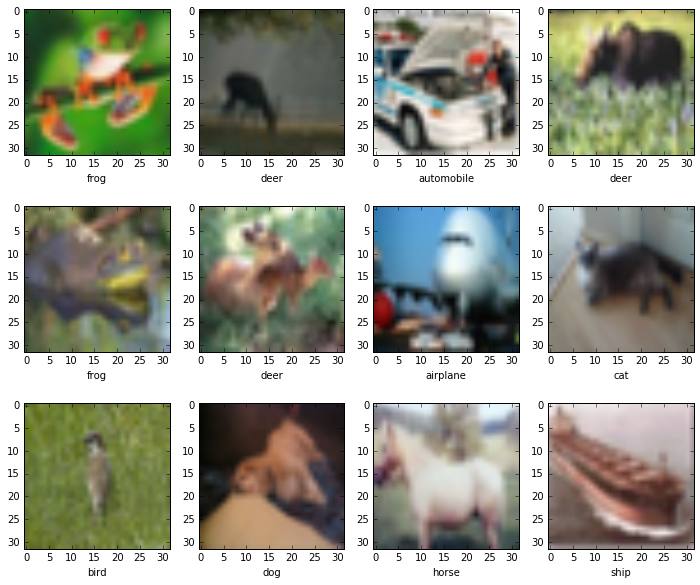

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12, 10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i], [1, 2, 0]))

# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano


In [5]:
import lasagne
import theano
import theano.tensor as T

input_X = T.tensor4("X")

#input dimention (None means "Arbitrary")
input_shape = [None, 3, 32, 32]

target_y = T.vector("target Y integer", dtype='int32')

Defining network architecture

In [6]:
#Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape=input_shape, input_var=input_X)

#fully connected layer, that takes input layer and applies 50 neurons to it.
# nonlinearity here is sigmoid as in logistic regression
# you can give a name to each layer (optional)
dense_1 = lasagne.layers.DenseLayer(input_layer, 
                                    num_units=100,
                                    nonlinearity = lasagne.nonlinearities.sigmoid,
                                    name = "hidden_dense_layer")

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
dense_output = lasagne.layers.DenseLayer(dense_1, 
                                         num_units = 10,
                                         nonlinearity = lasagne.nonlinearities.softmax,
                                         name='output')

In [7]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [8]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(dense_output, trainable=True)
print all_weights

[hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Lasagne builtins

In [9]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()

#prediction accuracy (WITH dropout)
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.sgd(loss, all_weights, learning_rate=0.01)

In [10]:
#function that computes loss and updates weights
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates=updates_sgd)

In [11]:
#deterministic prediciton (without dropout)
y_predicted_det = lasagne.layers.get_output(dense_output, deterministic=True)

#prediction accuracy (without dropout)
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det, target_y).mean()

#function that just computes accuracy without dropout/noize -- for evaluation purposes
accuracy_fun = theano.function([input_X, target_y], accuracy_det)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [12]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# X - a tensor of images with shape (many, 3, 32, 32), e.g. X_train
# y - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

#What do need to implement
# 1) Shuffle data
# - Gotta shuffle X and y the same way not to break the correspondence between X_i and y_i
# 3) Split data into minibatches of batch_size
# - If data size is not a multiple of batch_size, make one last batch smaller.
# 4) return a list (or an iterator) of pairs
# - (подгруппа картинок, ответы из y на эту подгруппу)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            padded = np.pad(inputs[excerpt], ((0, 0), (0, 0), (4, 4), (4, 4)), mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.random_integers(0, high=8, size=(batchsize, 2))
            for r in range(batchsize):
                random_cropped[r, :, :, :] = padded[r, :, crops[r, 0]:(crops[r, 0] + 32), 
                                                    crops[r, 1]:(crops[r, 1] + 32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

# Training loop

In [25]:
import time

num_epochs = 100 #amount of passes through the data
            
batch_size = 50 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 100 took 4.206s
  training loss (in-iteration):		1.352981
  train accuracy:		53.07 %
  validation accuracy:		48.94 %
Epoch 2 of 100 took 1.321s
  training loss (in-iteration):		1.351205
  train accuracy:		53.00 %
  validation accuracy:		49.07 %
Epoch 3 of 100 took 1.293s
  training loss (in-iteration):		1.348190
  train accuracy:		53.15 %
  validation accuracy:		49.33 %
Epoch 4 of 100 took 1.461s
  training loss (in-iteration):		1.345683
  train accuracy:		53.08 %
  validation accuracy:		48.44 %
Epoch 5 of 100 took 1.248s
  training loss (in-iteration):		1.342283
  train accuracy:		53.29 %
  validation accuracy:		49.18 %
Epoch 6 of 100 took 1.102s
  training loss (in-iteration):		1.339851
  train accuracy:		53.42 %
  validation accuracy:		48.86 %
Epoch 7 of 100 took 1.332s
  training loss (in-iteration):		1.337607
  train accuracy:		53.57 %
  validation accuracy:		49.12 %
Epoch 8 of 100 took 1.348s
  training loss (in-iteration):		1.334758
  train accuracy:		53.45 %
  valida

In [27]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 95:
    print "Double-check, than consider applying for NIPS'17. SRSly."
elif test_acc / test_batches * 100 > 90:
    print "U'r freakin' amazin'!"
elif test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: 110lvl Warlock!"
elif test_acc / test_batches * 100 > 70:
    print "Achievement unlocked: 80lvl Warlock!"
elif test_acc / test_batches * 100 > 50:
    print "Achievement unlocked: 60lvl Warlock!"
else:
    print "We need more magic!"

Final results:
  test accuracy:		51.44 %
Achievement unlocked: 60lvl Warlock!


# First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and ReLU activation
* 3x3 pooling (or set previous convolution stride to 3)
* Dense layer with 100-neurons and ReLU activation
* 10% dropout
* Output dense layer.

Train it with Adam optimizer with default params.

In [13]:
%load_ext autoreload
%autoreload 2

In [31]:
from step_one import *

Epoch 1 of 50 took 2.294s
  training loss (in-iteration):		2.083232
  train accuracy:		25.30 %
  validation accuracy:		37.27 %
Epoch 2 of 50 took 2.305s
  training loss (in-iteration):		1.777742
  train accuracy:		37.95 %
  validation accuracy:		41.57 %
Epoch 3 of 50 took 2.291s
  training loss (in-iteration):		1.670691
  train accuracy:		41.52 %
  validation accuracy:		43.97 %
Epoch 4 of 50 took 2.299s
  training loss (in-iteration):		1.599062
  train accuracy:		43.62 %
  validation accuracy:		46.05 %
Epoch 5 of 50 took 2.355s
  training loss (in-iteration):		1.542120
  train accuracy:		45.60 %
  validation accuracy:		47.12 %
Epoch 6 of 50 took 2.302s
  training loss (in-iteration):		1.497345
  train accuracy:		46.99 %
  validation accuracy:		48.10 %
Epoch 7 of 50 took 2.285s
  training loss (in-iteration):		1.461360
  train accuracy:		48.06 %
  validation accuracy:		48.99 %
Epoch 8 of 50 took 2.412s
  training loss (in-iteration):		1.434842
  train accuracy:		48.78 %
  validation acc

In [32]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 95:
    print "Double-check, than consider applying for NIPS'17. SRSly."
elif test_acc / test_batches * 100 > 90:
    print "U'r freakin' amazin'!"
elif test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: 110lvl Warlock!"
elif test_acc / test_batches * 100 > 70:
    print "Achievement unlocked: 80lvl Warlock!"
elif test_acc / test_batches * 100 > 50:
    print "Achievement unlocked: 60lvl Warlock!"
else:
    print "We need more magic!"

Final results:
  test accuracy:		56.57 %
Achievement unlocked: 60lvl Warlock!


# Second step

* Add batch_norm (with default params) between convolution and pooling

Re-train the network with the same optimizer

In [36]:
from step_two import *

Epoch 1 of 20 took 3.635s
  training loss (in-iteration):		1.908405
  train accuracy:		31.92 %
  validation accuracy:		41.21 %
Epoch 2 of 20 took 3.616s
  training loss (in-iteration):		1.616073
  train accuracy:		43.23 %
  validation accuracy:		46.75 %
Epoch 3 of 20 took 3.638s
  training loss (in-iteration):		1.479066
  train accuracy:		47.88 %
  validation accuracy:		49.60 %
Epoch 4 of 20 took 3.597s
  training loss (in-iteration):		1.396155
  train accuracy:		50.51 %
  validation accuracy:		51.42 %
Epoch 5 of 20 took 3.662s
  training loss (in-iteration):		1.338472
  train accuracy:		52.83 %
  validation accuracy:		52.40 %
Epoch 6 of 20 took 3.617s
  training loss (in-iteration):		1.292719
  train accuracy:		54.38 %
  validation accuracy:		53.22 %
Epoch 7 of 20 took 3.594s
  training loss (in-iteration):		1.256223
  train accuracy:		55.68 %
  validation accuracy:		53.70 %
Epoch 8 of 20 took 3.624s
  training loss (in-iteration):		1.220228
  train accuracy:		57.11 %
  validation acc

In [37]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 95:
    print "Double-check, than consider applying for NIPS'17. SRSly."
elif test_acc / test_batches * 100 > 90:
    print "U'r freakin' amazin'!"
elif test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: 110lvl Warlock!"
elif test_acc / test_batches * 100 > 70:
    print "Achievement unlocked: 80lvl Warlock!"
elif test_acc / test_batches * 100 > 50:
    print "Achievement unlocked: 60lvl Warlock!"
else:
    print "We need more magic!"

Final results:
  test accuracy:		55.81 %
Achievement unlocked: 60lvl Warlock!


# Quest For A Better Network

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)
    
## Bonus points

Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example "A super-small/fast NN that gets 80%" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)

## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([lasagne docs](http://lasagne.readthedocs.org))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
    `                        num_filters = n_neurons,`
    `                        filter_size = (filter width, filter height),`
    `                        nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc

 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
   
   
   
   
 
 
   
There is a template for your solution below that you can opt to use or throw away and write it your way

In [38]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

print X_train.shape, y_train.shape

(40000, 3, 32, 32) (40000,)


In [39]:
import sys
import os
import time
import string
import random
import pickle

import numpy as np
import theano
import theano.tensor as T
import lasagne

sys.setrecursionlimit(10000)

from lasagne.nonlinearities import softmax, rectify
from lasagne.layers import batch_norm


def build_cnn(input_var=None, n=5):
    def residual_block(l, increase_dim=False, projection=False):
        input_num_filters = l.output_shape[1]
        if increase_dim:
            first_stride = (2, 2)
            out_num_filters = input_num_filters * 2
        else:
            first_stride = (1, 1)
            out_num_filters = input_num_filters

        stack_1 = batch_norm(lasagne.layers.Conv2DLayer(l, 
                                                        num_filters=out_num_filters, 
                                                        filter_size=(3, 3), 
                                                        stride=first_stride, 
                                                        nonlinearity=rectify, 
                                                        pad='same', 
                                                        W=lasagne.init.HeNormal(gain='relu'), 
                                                        flip_filters=False))
        stack_2 = batch_norm(lasagne.layers.Conv2DLayer(stack_1, 
                                                        num_filters=out_num_filters, 
                                                        filter_size=(3, 3), 
                                                        stride=(1, 1), 
                                                        nonlinearity=None, 
                                                        pad='same', 
                                                        W=lasagne.init.HeNormal(gain='relu'), 
                                                        flip_filters=False))
        
        # add shortcut connections
        if increase_dim:
            if projection:
                projection = batch_norm(lasagne.layers.Conv2DLayer(l, 
                                                                   num_filters=out_num_filters, 
                                                                   filter_size=(1, 1), 
                                                                   stride=(2, 2), 
                                                                   nonlinearity=None, 
                                                                   pad='same', 
                                                                   b=None, 
                                                                   flip_filters=False))
                block = lasagne.layers.NonlinearityLayer(lasagne.layers.ElemwiseSumLayer([stack_2, projection]), 
                                                         nonlinearity=rectify)
            else:
                identity = lasagne.layers.ExpressionLayer(l, 
                                                          lambda X: X[:, :, ::2, ::2], 
                                                          lambda s: (s[0], s[1], s[2]//2, s[3]//2))
                padding = lasagne.layers.PadLayer(identity, [out_num_filters//4, 0, 0], batch_ndim=1)
                block = lasagne.layers.NonlinearityLayer(lasagne.layers.ElemwiseSumLayer([stack_2, padding]), 
                                                         nonlinearity=rectify)
        else:
            block = lasagne.layers.NonlinearityLayer(lasagne.layers.ElemwiseSumLayer([stack_2, l]), 
                                                     nonlinearity=rectify)
        return block

    # Building the network
    l_in = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_var)

    # first layer, output is 16 x 32 x 32
    l = batch_norm(lasagne.layers.Conv2DLayer(l_in, 
                                              num_filters=16, 
                                              filter_size=(3, 3), 
                                              stride=(1, 1), 
                                              nonlinearity=rectify, 
                                              pad='same', 
                                              W=lasagne.init.HeNormal(gain='relu'), 
                                              flip_filters=False))
    
    # first stack of residual blocks, output is 16 x 32 x 32
    for _ in range(n):
        l = residual_block(l)

    # second stack of residual blocks, output is 32 x 16 x 16
    l = residual_block(l, increase_dim=True)
    
    for _ in range(1, n):
        l = residual_block(l)

    # third stack of residual blocks, output is 64 x 8 x 8
    l = residual_block(l, increase_dim=True)
    
    for _ in range(1, n):
        l = residual_block(l)
    
    # average pooling
    l = lasagne.layers.GlobalPoolLayer(l)

    network = lasagne.layers.DenseLayer(l, 
                                        num_units=10,
                                        W=lasagne.init.HeNormal(),
                                        nonlinearity=softmax)
    return network

In [45]:
def main(n=5, num_epochs=20, model=None):
    # Load the dataset
    print("Loading data...")
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_cifar10("cifar_data")

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')
    
    # Create neural network model
    print("Building model and compiling functions...")
    network = build_cnn(input_var, n)
    print("number of parameters in model: %d" % lasagne.layers.count_params(network, trainable=True))
    
    if model is None:
        # Create a loss expression for training, i.e., a scalar objective we want
        # to minimize (for our multi-class problem, it is the cross-entropy loss):
        prediction = lasagne.layers.get_output(network)
        loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
        loss = loss.mean()
        # add weight decay
        all_layers = lasagne.layers.get_all_layers(network)
        l2_penalty = lasagne.regularization.regularize_layer_params(all_layers, lasagne.regularization.l2) * 0.0001
        loss = loss + l2_penalty

        # Create update expressions for training
        # Stochastic Gradient Descent (SGD) with momentum
        params = lasagne.layers.get_all_params(network, trainable=True)
        lr = 0.1
        sh_lr = theano.shared(lasagne.utils.floatX(lr))
        updates = lasagne.updates.momentum(loss, params, learning_rate=sh_lr, momentum=0.9)
        
        # Compile a function performing a training step on a mini-batch (by giving
        # the updates dictionary) and returning the corresponding training loss:
        train_fn = theano.function([input_var, target_var], loss, updates=updates)

    # Create a loss expression for validation/testing
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    if model is None:
        print("Starting training...")
        # We iterate over epochs:
        for epoch in range(num_epochs):
            # In each epoch, we do a full pass over the training data:
            train_err = 0
            train_batches = 0
            start_time = time.time()
            for batch in iterate_minibatches(X_train, Y_train, 128, shuffle=True, augment=True):
                inputs, targets = batch
                train_err += train_fn(inputs, targets)
                train_batches += 1

            # And a full pass over the validation data:
            val_err = 0
            val_acc = 0
            val_batches = 0
            for batch in iterate_minibatches(X_val, Y_val, 500, shuffle=False):
                inputs, targets = batch
                err, acc = val_fn(inputs, targets)
                val_err += err
                val_acc += acc
                val_batches += 1

            # Then we print the results for this epoch:
            print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
            print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
            print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
            print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

            # adjust learning rate as in paper
            # 32k and 48k iterations should be roughly equivalent to 41 and 61 epochs
            if (epoch + 1) == 41 or (epoch + 1) == 61:
                new_lr = sh_lr.get_value() * 0.1
                print("New LR:" + str(new_lr))
                sh_lr.set_value(lasagne.utils.floatX(new_lr))

        # dump the network weights to a file :
        np.savez('cifar10_deep_residual_model.npz', *lasagne.layers.get_all_param_values(network))
    else:
        # load network weights from model file
        with np.load(model) as f:
             param_values = [f['arr_%d' % i] for i in range(len(f.files))]
        lasagne.layers.set_all_param_values(network, param_values)

    # Calculate validation error of model:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, Y_test, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))


In [46]:
main()

Loading data...
Building model and compiling functions...
number of parameters in model: 464154
Starting training...
Epoch 1 of 20 took 1326.524s
  training loss:		2.391771
  validation loss:		1.792913
  validation accuracy:		34.99 %
Epoch 2 of 20 took 4847.057s
  training loss:		1.796505
  validation loss:		1.500909
  validation accuracy:		47.93 %
Epoch 3 of 20 took 1388.897s
  training loss:		1.468733
  validation loss:		1.225463
  validation accuracy:		57.31 %
Epoch 4 of 20 took 1381.699s
  training loss:		1.266186
  validation loss:		1.073558
  validation accuracy:		64.21 %
Epoch 5 of 20 took 1360.836s
  training loss:		1.108707
  validation loss:		1.184080
  validation accuracy:		63.26 %
Epoch 6 of 20 took 1394.948s
  training loss:		1.006165
  validation loss:		0.744925
  validation accuracy:		74.12 %
Epoch 7 of 20 took 1383.973s
  training loss:		0.933450
  validation loss:		0.694638
  validation accuracy:		75.60 %
Epoch 8 of 20 took 1370.740s
  training loss:		0.877059
  valida

# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

In [36]:
from IPython.display import Image

## Hi, my name is `Anastasia Feygina`, and here's my story

A long ago in a galaxy far far away, when it was still more than an hour before deadline, i got an idea:

### I gonna build a neural network, that
...does magic.


### Sad reality:

First step

Let's create a mini-convolutional network with roughly such architecture:
*  Input layer
*  3x3 convolution with 10 filters and ReLU activation
*  3x3 pooling (or set previous convolution stride to 3)
*  Dense layer with 100-neurons and ReLU activation
*  10% dropout
*  Output dense layer.
Train it with Adam optimizer with default params.

**with batch_size = 500, num_epochs = 50 I have test accuracy: 56.57 %, before that it was worse with batch_size = 50 and num_epochs = 15... Net has been quickly retrained.**


Then:

Second step
 
* Add batch_norm (with default params) between convolution and pooling
* Re-train the network with the same optimizer

**Here I had test accuracy: 55.81 %, so it's even worse then before. I can't say why is that, just guessing... but I tried to play with batch_size and num_epoch, still couldn't help it. **

Then I thought how to improve my results:

**Simply stacking layers?**

But 56-layer net has higher training error and test error than 20-layer net

**So, I've tried my chanses with general ideas like vgg, ResNet and inception. And I was lucky enouhgt to find this slides http://icml.cc/2016/tutorials/icml2016_tutorial_deep_residual_networks_kaiminghe.pdf that made me think about ResNet as of the best thing to try here.**

**The most interesting part of this slides starts on 58 page. I've tried (a) and (e)**

![title](picture.png)

How could i be so naive?!

**Thinking that training nets on my laptop is a good idea**

So having architecture:

* InputLayer
* Conv2DLayer (16 x 32 x 32, relu, stride)
* 1 residual block (16 x 32 x 32) x 5
* residual blok with increase_dim (32 x 16 x 16)
* 2 residual block (32 x 16 x 16) x 5
* residual blok with increase_dim (64 x 8 x 8)
* 3 residual block (64 x 8 x 8) x 5
* GlobalPoolLayer
* DenseLayer (num_units=10, softmax)

residual block = (a) on the picture above

btw, each ConvLayer had batch_norm and pooling.

![title](training.png)

I was stupid enought to set 50 epochs and wake up relizing that 20 is actually enought, because training loss is keep decreasing, but validation loss is growing. 

I tried the same thing with residual block = (e) on the picture above, but didn't see any evident difference. But I think that is because of time-eating testing and I did have enought patience. 

### Finally, after __  iterations, __ mugs of [tea/coffee]
* final architecture is the one that I showed above
* training method...it's easier to show it like this:

l2_penalty = lasagne.regularization.regularize_layer_params(all_layers, lasagne.regularization.l2) * 0.0001

loss = loss + l2_penalty

Stochastic Gradient Descent (SGD) with momentum

params = lasagne.layers.get_all_params(network, trainable=True)

updates = lasagne.updates.momentum(loss, params, learning_rate=0.1, momentum=0.9)

Here,too, a place is left to play with Adam for example...


That, having wasted 8 [hours] of my life training (100000000000000 hourse on home work), got

* accuracy on training: 80.3
* accuracy on validation: 83.7
* accuracy on test: 82.66

[an optional afterword and mortal curses on assignment authors]

I also liked http://colah.github.io/posts/2014-07-Understanding-Convolutions/ and
http://colah.github.io/posts/2014-07-Conv-Nets-Modular/

Amen!